In [ ]:
# Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import joblib
import pickle
from sklearn import tree

In [ ]:
# Cargar los datasets de entrenamiento y testeo analizados en el proyecto anterior
with open('../data/processed/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('../data/processed/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('../data/processed/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
# Valido la tamaño de los dataframes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 6)
(154, 6)
(614,)
(154,)


In [11]:
# Inicializcion y entrenamiento del modelo
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

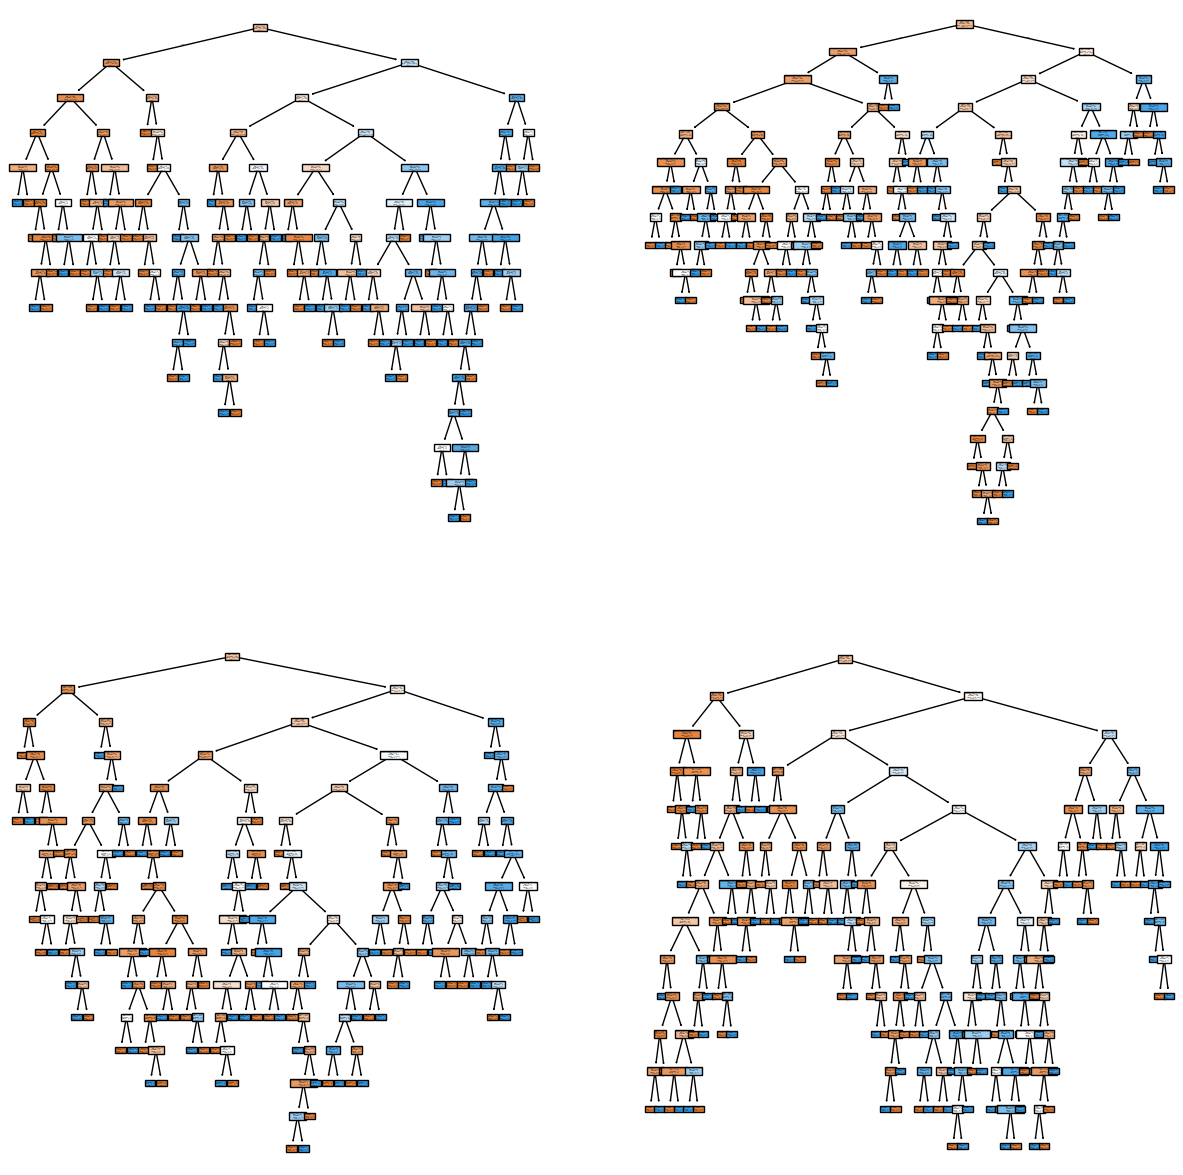

In [ ]:
# Mostramos los 4 primeros arboles
fig, axis = plt.subplots(2, 2, figsize = (15, 15))

tree.plot_tree(model.estimators_[0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

In [ ]:
#Una vez entrenado el modelo, se puede utilizar para realizar predicciones con el conjunto de datos
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [14]:
# Validacion de metricas
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [17]:
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.772727,0.690265,0.758586,0.672414,0.709091,0.808081
Diferencia,0.227273,0.309735,0.241414,0.327586,0.290909,0.191919


Analisis: Se nota que el modelo esta aprendiendo y prediciendo los datos de entrenamiento en su totalidad ya que obtenemos todos los resultados de las metricas en 100% frente a los datos de testeo que estan entre 67% y maximo 80% de acierto en la precision y especificidad respectivamente, por ejemplo. Procederemos a intentar mejorar estas metricas con algoritmos para hiperparametros.

# Optimizacion de hiperparametros

In [21]:
# Definimos el algoritmo base
estimador = LGBMRegressor()

# Definimos el espacio de búsqueda
hp_dict = {'n_estimators': [5, 50, 100],
           'max_depth': [20, 30, 40],
           'min_samples_split': [30, 40, 50, 60]}

# Definimos el como queremos buscar
random_search = RandomizedSearchCV(estimador, hp_dict, n_iter=10, scoring='r2', cv = 5, random_state = 42, n_jobs = -1, verbose = 3)

In [22]:
# Iniciamos la búsqueda
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] Start training from score 0.362525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [20, 30, 40],
                                        'min_samples_split': [30, 40, 50, 60],
                                        'n_estimators': [5, 50, 100]},
                   random_state=42, scoring='r2', verbose=3)

In [23]:
random_search.best_params_

{'n_estimators': 50, 'min_samples_split': 30, 'max_depth': 30}

In [24]:
# Busqueda bayesiana
# Definimos el algoritmo base
estimador = LGBMRegressor()

# Definimos el espacio de búsqueda
hp_dict_1 = {'n_estimators': [30, 50, 70],
           'max_depth': [10, 20, 30, 40],
           'min_child_samples': [20, 30, 40, 50]}

bayes_search = BayesSearchCV(estimador, hp_dict_1, n_iter=10, scoring='r2', cv = 5, random_state = 42, n_jobs = -1, verbose = 3)

In [25]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] Start training from score 0.362525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] Start training from score 0.338086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

BayesSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=10, n_jobs=-1,
              random_state=42, scoring='r2',
              search_spaces={'max_depth': [10, 20, 30, 40],
                             'min_child_samples': [20, 30, 40, 50],
                             'n_estimators': [30, 50, 70]},
              verbose=3)

In [26]:
bayes_search.best_params_

OrderedDict([('max_depth', 40),
             ('min_child_samples', 50),
             ('n_estimators', 30)])

In [27]:
# Nuevo modelo random con hiperparametros mejorados
modelo2 = RandomForestClassifier(n_estimators=30, max_depth=40, min_samples_leaf=50, random_state=42)
modelo2.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=50, n_estimators=30,
                       random_state=42)

In [28]:
#Una vez entrenado el modelo 2, se puede utilizar para realizar predicciones con el conjunto de datos
y_test_pred2 = modelo2.predict(X_test)
y_train_pred2 = modelo2.predict(X_train)

In [ ]:
# Nuevas metricas, para el modelo 2
get_metrics(y_train, y_test, y_train_pred2, y_test_pred2)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.781759,0.614943,0.716261,0.792593,0.502347,0.930175
Test,0.759740,0.618557,0.712121,0.714286,0.545455,0.878788
Diferencia,0.022019,-0.003614,0.004140,0.078307,-0.043107,0.051387


In [ ]:
# Metricas anteriores para comparar
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.772727,0.690265,0.758586,0.672414,0.709091,0.808081
Diferencia,0.227273,0.309735,0.241414,0.327586,0.290909,0.191919


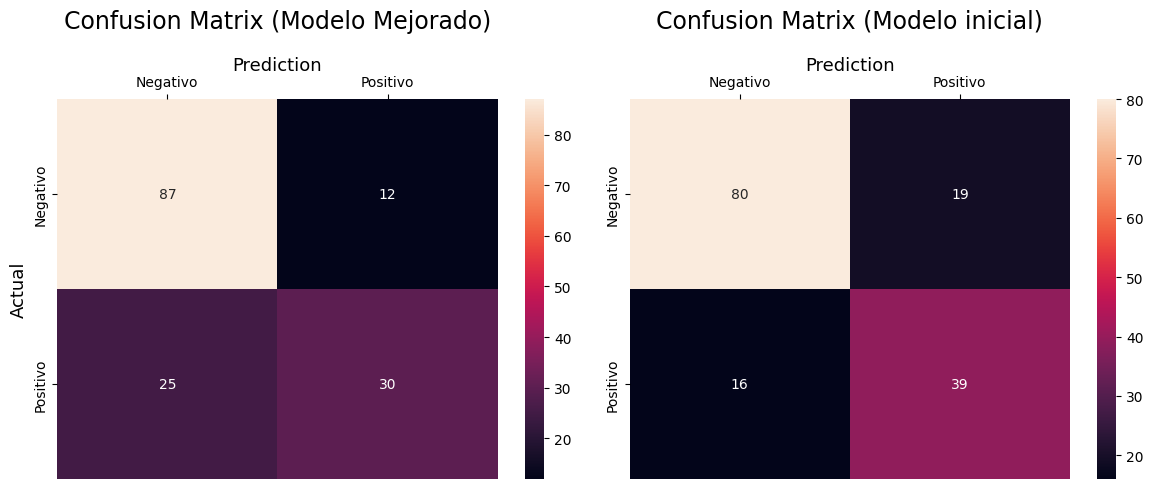

In [32]:
# Calcular las matrices de confusión para ambos modelos
cm_model = confusion_matrix(y_test, y_test_pred)  # Matriz de confusión del modelo
cm_modelo2 = confusion_matrix(y_test, y_test_pred2)    # Matriz de confusión del modelo2 mejorado

# Crear una figura con dos subgráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico 1: Matriz de confusión del modelo complejo (izquierda)
sns.heatmap(cm_modelo2, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax1)
ax1.set_ylabel('Actual', fontsize=13)
ax1.set_title('Confusion Matrix (Modelo Mejorado)', fontsize=17, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Prediction', fontsize=13)
ax1.xaxis.tick_top()

# Gráfico 2: Matriz de confusión del modelo simple (derecha)
sns.heatmap(cm_model, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax2)
ax2.set_title('Confusion Matrix (Modelo inicial)', fontsize=17, pad=20)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Prediction', fontsize=13)
ax2.xaxis.tick_top()

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Analisis final: El modelo con los hiperparametros mejorados solo logra mejores metricas en precision y especificidad en los datos de prueba, la exactitud, F1, area bajo la curva y recall siguen siendo mejores en el modelo obtenido con los datos por defecto.

De la matriz de confusion se ve como aunque el modelo optimizado gana 7 predicciones negativas, en las predicciones positivas es mucho mejor el modelo sin optimizacion.